In [274]:
import __init__

In [358]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [276]:
# Load external librairies
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Load internal librairies
from fleming_lib.dataset import create_dataset
from fleming_lib.severity_scores import compute_sapsii_score
from fleming_lib.utils import add_categories

from fleming_lib.metrics import add_target, add_age
from fleming_lib.preprocessing import fill_last_upto

In [336]:
import pickle as pkl

In [280]:
# Open a connection to OMOP
from fleming_lib.tools import connect_to_omop
conn = connect_to_omop()
# fct to create dataset
from fleming_lib.dataset import create_dataset

## Extract a subcohort of interest

In [254]:
# not be "limited"
query_lim = """
select
    distinct person_id
from 
    measurement 
where 
    measurement_source_concept_id in (2001018843, 2001030812, 4127294)  
    ;"""

limitation = pd.read_sql_query(query_lim, conn)

# in ICU

query_icu = """
        select person_id
        from visit_detail
        where visit_detail_concept_id = 581382              
        and visit_type_concept_id = 2000000006 
;"""

icu = pd.read_sql_query(query_icu, conn)

# age > 15
query_age = """
with person_age as (
    select
        p.person_id, (v.visit_start_date - p.birth_datetime)/365.25 age
    from
        person p
    left outer join
        visit_occurrence v
    on
        p.person_id = v.person_id)
select
    person_id, age
from
    person_age
where
    age > 15            -- including persons older than 15
and 
    age < 150             -- removing any outliers
;"""

age = pd.read_sql_query(query_age, conn)

# query died

query_died = """SELECT person_id FROM death ;"""

died = pd.read_sql_query(query_died, conn)

In [44]:
list_patient = list(set(icu.person_id) & set(age.person_id) & set(limitation.person_id))
list_patient[:10]

[62063367,
 62063368,
 62063369,
 62063370,
 62063371,
 62063372,
 62063373,
 62063374,
 62063377,
 62063378]

In [45]:
len(list_patient)

31056

In [46]:
list_patient_died = list(set(icu.person_id) & set(age.person_id) & set(limitation.person_id)& set(died.person_id) )
list_patient_died[:10]

[62095360,
 62095367,
 62095371,
 62095374,
 62095375,
 62095377,
 62095379,
 62095380,
 62095382,
 62095385]

In [47]:
len(list_patient_died)

12010

In [48]:
truly_alive = np.setdiff1d(list_patient, list_patient_died)

In [50]:
list(truly_alive[:10])

[62063367,
 62063369,
 62063370,
 62063371,
 62063372,
 62063373,
 62063378,
 62063379,
 62063381,
 62063382]

In [189]:
len(truly_alive)

19046

## Build dataset for each patient

In [5]:
patient_id = (62063368, 62063378)  # person_id

In [269]:
import time
import warnings

from fleming_lib.metrics import add_rolling_avg, add_target, add_super_target, add_age
from fleming_lib.utils import to_categorical, to_onehot, to_numeric, convert_frac, add_categories, add_missing_columns, check_length


In [286]:
def create_dataset(list_patients, n_patients_per_batch=10, verbose=False):
    """Create list of dataset given a list of patients.
    
    Parameters
    ----------
    list_patients : list of int
        List of patients ID.
    n_patients_per_batch : int (default=10)
        Number of patients to sequentially load data for, in order not to cause timeout if the query is too long to
        process by the server.
    verbose : bool (default=False)
        Verbosity level.
    
    Returns
    -------
    dataset : pd.DataFrame
        Dataset containing all data associated to each patient.
        
    """
    t0 = time.time()
    frame = []
    
    if not isinstance(list_patients, list):
        list_patients = [list_patients]
        
    n_patients = len(list_patients)
    
    # Extract meta data
    # -----------------
    if verbose:
        msg = 'Extracting meta data...'
        delta_t = str(int(time.time() - t0)) + ' s'
        print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            
    query = """     
    
        select 
            distinct p.person_id, p.gender_source_value gender, p.race_source_value race, p.birth_datetime 
        from person p
        
        ;"""
    print('   start meta...        ', end='\r')
    meta = pd.read_sql_query(query, conn)
    print('...end meta            ', end='\r')
    # Dictionary containing unique categories for each categorical variable
    categories = dict()
    
    # Convert categorical variable to 'categorical' type
    categorical_variables = ['gender', 'race']
    # Extracting categories for each categorical variable
    categories = add_categories(categories, meta, categorical_variables)
    
    meta = to_categorical(meta, categorical_variables, categories)
    meta = to_onehot(meta, categorical_variables)
    # One-hot column names
    meta_names = meta.columns
    
    # Extract unique measurements values from categorical variables
    # (here 'Heart rate rhythm' and 'Admission Type')
    query = """
        select
            distinct m.measurement_concept_name, m.value_source_value
        from 
            measurement m 
        where
            m.measurement_concept_id in
            (3022318   -- heart_rhythm
            )
        order by
            m.measurement_concept_name, m.value_source_value     
        ;"""

    unique_categ_values = pd.read_sql_query(query, conn)
    categorical_variables = ['Heart rate rhythm']
    # Adding categories of each categorical variables to dict 'categories'
    for var in categorical_variables:
        tmp = unique_categ_values.loc[unique_categ_values.measurement_concept_name == var]
        tmp.drop('measurement_concept_name', axis=1, inplace=True)
        tmp.rename(index=str, columns={'value_source_value': var}, inplace=True)
        categories = add_categories(categories, tmp, var)
    
    # Create sublist of patients (batch)
    n_iter = int(n_patients / n_patients_per_batch)
    sublists_patients = [list_patients[i: i+n_patients_per_batch]
                         for i in range(0, n_patients, n_patients_per_batch)]
    n_sublists = len(sublists_patients)
    
    # Extracting data for each patient
    for i, sublist_patients in enumerate(sublists_patients):
        if verbose:
            base_msg = 'Batch {}/{}'.format(i+1, n_sublists)
            msg = base_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
        
        # Extract measures
        # ----------------
        if verbose:
            add_msg = 'Extracting measures...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            
        if len(sublist_patients) == 1:
            match_person = "m.person_id = {}".format(sublist_patients[0])
        else:
            match_person = "m.person_id in {}".format(tuple(sublist_patients))
            
        query = """ 
          
        select
            distinct m.person_id, m.measurement_datetime, m.measurement_concept_name, m.value_source_value, 
            m.unit_source_value, d.death_datetime
        from 
            measurement m
        left join 
            death d on d.person_id = m.person_id

        where
            measurement_concept_id IN
            (3022318,   -- heart_rhythm
             3024171,   -- respiratory_rate
             3028354,   -- vent_settings
             3012888,   -- diastolic_bp
             3027598,   -- map_bp
             3004249,   -- systolic_bp
             3027018,   -- heart_rate
             3020891,   -- temperature
             3016502,   -- spo2
             3020716,   -- fio2
             -- 4233883,   -- spo2/fio2          , to compare with the previous 
             3032652,   -- glasgow coma scale
     
             -- chemicals
             3019550,   -- sodium serum/plasma (en) | natremie (fr)
             3023103,   -- potassium serum/plasma (en) | kaliemie (fr)
             3024128,   -- bilirubin
             
             -- hemato
             3003282    -- Leukocytes [#/volume] in Blood by Manual count
             
             -- sofa materials 
             -- 3016723    -- creatinine
             
            )
    
        and {}
        order by measurement_datetime
            ;""".format(match_person)
        
        df = pd.read_sql_query(query, conn)

        # Check if data is empty for a patient
        check_length(df)

        if verbose:
            add_msg = 'Formatting data...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')

        df['death_datetime'] = pd.to_datetime(df['death_datetime'])
        df['measurement_datetime'] = pd.to_datetime(df['measurement_datetime'])
        
        # Add target: patient's death' status, relative to the measurement datetime (target) and to the hospital stay (super_target)
        df = df.groupby('person_id').apply(add_target)
        df = df.groupby('person_id').apply(add_super_target)
        
        # Convert to timeseries matrix
        df = df.pivot_table(index= ['measurement_datetime','target','super_target','person_id'], 
                            columns='measurement_concept_name', values='value_source_value', aggfunc='first')
        df.reset_index(inplace=True)
        df.columns.name = None
        
        # Convert types
        # -------------
        # Convert to numerical
        numerical_variables = ['BP diastolic', 'BP systolic', 'Body temperature', 'Heart rate', 'Mean blood pressure',
                               'Glasgow coma scale', 'Oxygen concentration breathed', 
                               'Mean pressure Respiratory system airway Calculated', 
                               'Oxygen saturation in Arterial blood', 'Respiratory rate',
                               'Leukocytes [#/volume] in Blood by Manual count',
                               'Potassium serum/plasma', 'Sodium serum/plasma', 'Total Bilirubin serum/plasma']
                               #'Ratio of arterial oxygen tension to inspired oxygen fraction' ]
           
        df = add_missing_columns(df, numerical_variables)
    
        df = convert_frac(df, numerical_variables)
        df = to_numeric(df, numerical_variables)
        
        #creatinine : convert to mg/L
        # df["Creatinine serum/plasma"]=10*df["Creatinine serum/plasma"]
        #bilurin : convert to umol/L
        # df["Total Bilirubin serum/plasma"]=17.1*df["Total Bilirubin serum/plasma"]
        
        # Convert to categorical and one-hot encode
        categorical_variables = ['Heart rate rhythm']
        
        df = add_missing_columns(df, categorical_variables)
        
        df = to_categorical(df, categorical_variables, categories)
        df = to_onehot(df, categorical_variables)
        
        
        # Add meta data to measures
        # -------------------------
        if verbose:
            add_msg = 'Adding meta data...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            
        df = pd.merge(df, meta, how='inner', on='person_id')
        
        # Add additional features
        # -----------------------
        if verbose:
            add_msg = 'Adding additional features...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
        
        # - age
        df = df.groupby('person_id').apply(add_age, round_to_dec=1)
        # - 2h rolling average respiratory rate
        df = df.groupby('person_id').apply(add_rolling_avg, column='Respiratory rate', window=2)
        
        frame.append(df)
        
        if verbose:
            add_msg = 'Done'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            print('')
            
    # Concat dataframes
    dataset = pd.concat(frame)
    dataset = dataset.reindex(frame[0].columns, axis=1)
    
    return dataset

## DEAD

In [271]:
# Define list of patients
# Create dataset
list_patients_dead = list_patient_died[:100]
dataset_dead = create_dataset(list_patients_dead, verbose=True, n_patients_per_batch=10)

Batch 1/10 - Done                                                                                    [36 s      ]
Batch 2/10 - Done                                                                                    [48 s      ]
Batch 3/10 - Done                                                                                    [63 s      ]
Batch 4/10 - Done                                                                                    [78 s      ]
Batch 5/10 - Done                                                                                    [89 s      ]
Batch 6/10 - Done                                                                                    [104 s     ]
Batch 7/10 - Done                                                                                    [117 s     ]
Batch 8/10 - Done                                                                                    [142 s     ]
Batch 9/10 - Done                                                                       

In [317]:
df_dead = dataset_dead.copy(deep=True)

In [319]:
# veeery long to run (several minutes for 100 ids)
df_dead = df_dead.groupby('person_id', group_keys=False).apply(fill_last_upto, h=timedelta(hours=24))
# Sort index
df_dead.sort_index(inplace=True)

In [320]:
df_dead_filled = df_dead

In [321]:
df_dead_filled['Body temperature'] = df_dead_filled['Body temperature'].apply(pd.to_numeric, errors='coerce')

In [322]:
dfBodyTempC_dead = df_dead_filled['Body temperature'].copy()
dfBodyTempC_dead = pd.DataFrame([(tempF-32.0)/1.8 if float(tempF)>65.0 else tempF for tempF in dfBodyTempC_dead.values], index = df_dead_filled.index)
df_dead_filled = df_dead_filled.assign(bodyTemperature_C = dfBodyTempC_dead.values)

In [335]:
df_dead_filled.to_csv('/Users/jeremydesir/Desktop/DataForMe/df_dead.csv')

In [337]:
pkl.dump(df_dead_filled, open('df_dead_filled' + '.pkl', 'wb'))

In [345]:
#df_patiens_dead = []
#for id_ in list_patients_dead:
#    df_id = df_dead[df_dead.person_id == id_]
#    df_patiens_dead+=[df_id]

# Extracting dataframe for each patient
list_df_patiens_dead = dict()
patients_id_dead = []

for patient_id, sub_df in df_dead_filled.groupby('person_id'):
    # Set relative time scale
    sub_df.reset_index(drop=True, inplace=True)
    start_date = sub_df['measurement_datetime'][0]
    sub_df['measurement_datetime'] -= start_date
    list_df_patiens_dead[patient_id] = sub_df
    patients_id_dead.append(patient_id)

/Users/jeremydesir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [349]:
list_df_patiens_dead[62095360].head()

,measurement_datetime,target,super_target,person_id,BP diastolic,BP systolic,Body temperature,Glasgow coma scale,Heart rate,Leukocytes [#/volume] in Blood by Manual count,...,race_UNKNOWN/NOT SPECIFIED,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,race_NaN,age,Respiratory rate avg h-2,bodyTemperature_C
0,00:00:00,0,1,62095360,NaT,NaT,NaN,NaT,NaT,22.6,...,0,1,0,0,0,0,0,62.1,NaT,NaN
1,06:55:00,0,1,62095360,93,155,96.800003,15,104,22.6,...,0,1,0,0,0,0,0,62.1,NaT,36.000002
2,07:10:00,0,1,62095360,77,166,96.800003,15,109,22.6,...,0,1,0,0,0,0,0,62.1,20,36.000002
3,07:25:00,0,1,62095360,79,159,96.800003,15,110,22.6,...,0,1,0,0,0,0,0,62.1,21,36.000002
4,07:40:00,0,1,62095360,77,155,96.800003,15,107,22.6,...,0,1,0,0,0,0,0,62.1,21.3333,36.000002


## ALIVE

In [287]:
# Define list of patients
# Create dataset
list_patients_alive =truly_alive[:100]
dataset_alive = create_dataset(list_patients_alive, verbose=True, n_patients_per_batch=10)

Batch 1/10 - Done                                                                                    [27 s      ]
Batch 2/10 - Done                                                                                    [35 s      ]
Batch 3/10 - Done                                                                                    [55 s      ]
Batch 4/10 - Done                                                                                    [60 s      ]
Batch 5/10 - Done                                                                                    [70 s      ]
Batch 6/10 - Done                                                                                    [85 s      ]
Batch 7/10 - Done                                                                                    [100 s     ]
Batch 8/10 - Done                                                                                    [106 s     ]
Batch 9/10 - Done                                                                       

In [330]:
df_alive = dataset_alive.copy(deep=True)

In [331]:
df_alive = df_alive.groupby('person_id', group_keys=False).apply(fill_last_upto, h=timedelta(hours=24))
# Sort index
df_alive.sort_index(inplace=True)

In [332]:
df_alive_filled = df_alive

In [333]:
df_alive_filled['Body temperature'] = df_alive_filled['Body temperature'].apply(pd.to_numeric, errors='coerce')

In [334]:
dfBodyTempC_alive = df_alive['Body temperature'].copy()
dfBodyTempC_alive = pd.DataFrame([(tempF-32.0)/1.8 if tempF>65 else tempF for tempF in dfBodyTempC_alive.values], index = df_alive_filled.index)
df_alive_filled = df_alive_filled.assign(bodyTemperature_C = dfBodyTempC_alive.values)

In [338]:
df_alive_filled.to_csv('/Users/jeremydesir/Desktop/DataForMe/df_alive.csv')

In [339]:
pkl.dump(df_alive_filled, open('df_alive_filled' + '.pkl', 'wb'))

In [298]:
df_patients_alive = []
for id_ in list_patients_alive:
    df_id = df_alive[df_alive.person_id == id_]
    df_patients_alive+=[df_id]

In [350]:
list_df_patiens_alive = dict()
patients_id_alive = []

for patient_id, sub_df in df_alive_filled.groupby('person_id'):
    # Set relative time scale
    sub_df.reset_index(drop=True, inplace=True)
    start_date = sub_df['measurement_datetime'][0]
    sub_df['measurement_datetime'] -= start_date
    list_df_patiens_alive[patient_id] = sub_df
    patients_id_alive.append(patient_id)

/Users/jeremydesir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# COMPUTE SCORE

# DEAD

In [120]:
#df_dead_droped = list_df_dead_alive[0]

In [121]:
#df_alive_droped = list_df_dead_alive[1]

In [490]:
sapsii_components_dead = df_dead_filled[['person_id', 'age', 'Glasgow coma scale', 'BP systolic', 'bodyTemperature_C',
                                       'Oxygen saturation in Arterial blood', 'Oxygen concentration breathed',
                                       'Leukocytes [#/volume] in Blood by Manual count',
                                       'Potassium serum/plasma', 'Sodium serum/plasma', 'Total Bilirubin serum/plasma']]

In [495]:
sapsii_scores_dead = []
list_df_scores_dead = []

for patient_id in list_patients_dead:
    sapsii_components_dead_id = sapsii_components_dead[sapsii_components_dead.person_id == patient_id]
    sapsii_components_dead_id = sapsii_components_dead_id.apply(compute_sapsii_score, axis=1) 
    values = sapsii_components_dead_id.values
    if values.size > 100 :
        list_df_scores_dead.append(sapsii_components_dead_id)
        sapsii_scores_dead.append(values)

In [496]:
conc_dead = pd.concat(list_df_scores_dead, axis = 1)

In [497]:
dead_mean_score = conc_dead.mean(axis=1)

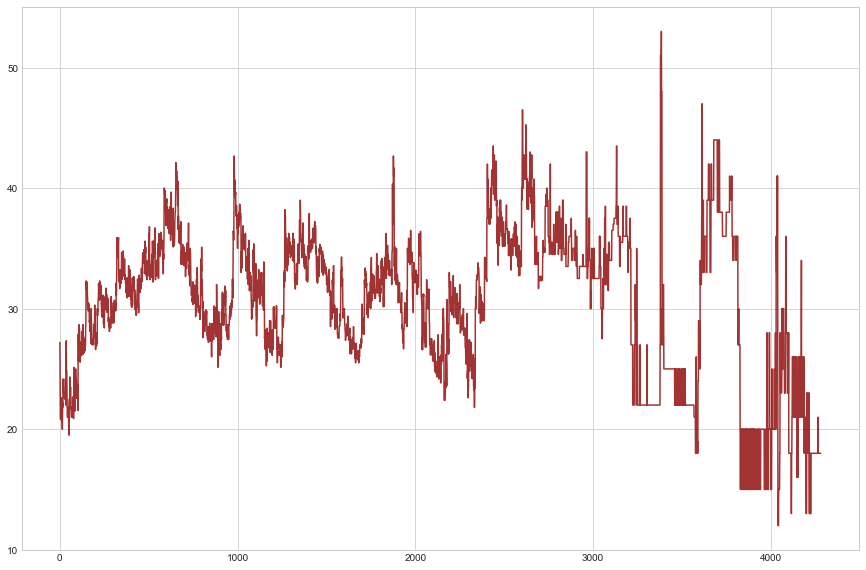

In [498]:
dead_mean_score.plot(figsize=(15, 10), color="darkred", label="Score moyen", alpha=0.8)

# ALIVE

In [469]:
sapsii_components_alive = df_alive_filled[['person_id', 'age', 'Glasgow coma scale', 'BP systolic', 'bodyTemperature_C',
                                       'Oxygen saturation in Arterial blood', 'Oxygen concentration breathed',
                                       'Leukocytes [#/volume] in Blood by Manual count',
                                       'Potassium serum/plasma', 'Sodium serum/plasma', 'Total Bilirubin serum/plasma']]

In [499]:
sapsii_scores_alive = []
list_df_scores_alive = []

for patient_id in list_patients_alive:
    sapsii_components_alive_id = sapsii_components_alive[sapsii_components_alive.person_id == patient_id]
    sapsii_components_alive_id = sapsii_components_alive_id.apply(compute_sapsii_score, axis=1) 
    values = sapsii_components_alive_id.values
    if values.size > 100 :
        list_df_scores_alive.append(sapsii_components_alive_id)
        sapsii_scores_alive.append(values)

In [500]:
conc_alive = pd.concat(list_df_scores_alive, axis = 1)

In [501]:
conc_alive.shape

(3846, 53)

In [502]:
alive_mean_score = conc_alive.mean(axis=1)

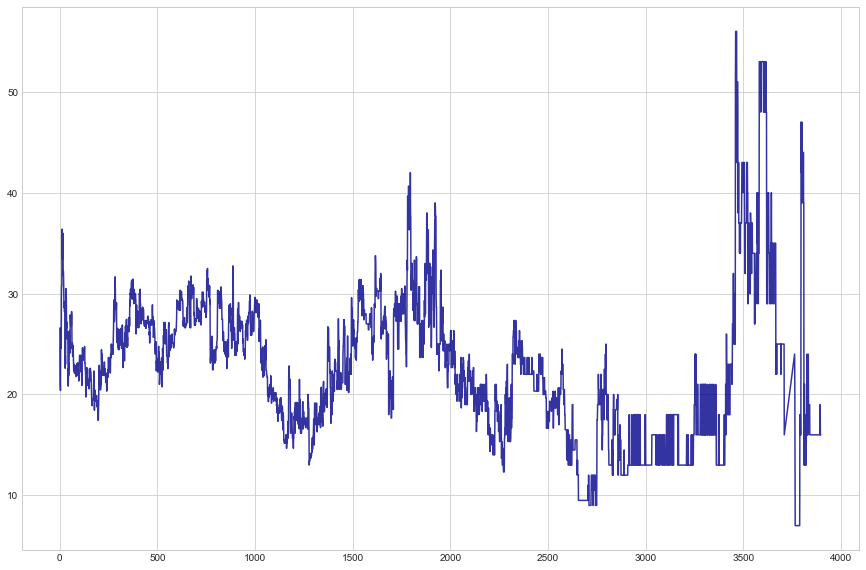

In [503]:
alive_mean_score.plot(figsize=(15, 10), color="darkblue", label="Score moyen", alpha=0.8)

In [504]:
value_max = 0
sapsii_scores = sapsii_scores_dead + sapsii_scores_alive
for values in sapsii_scores:
    if values.size > value_max:
        value_max = values.size
value_max

2152

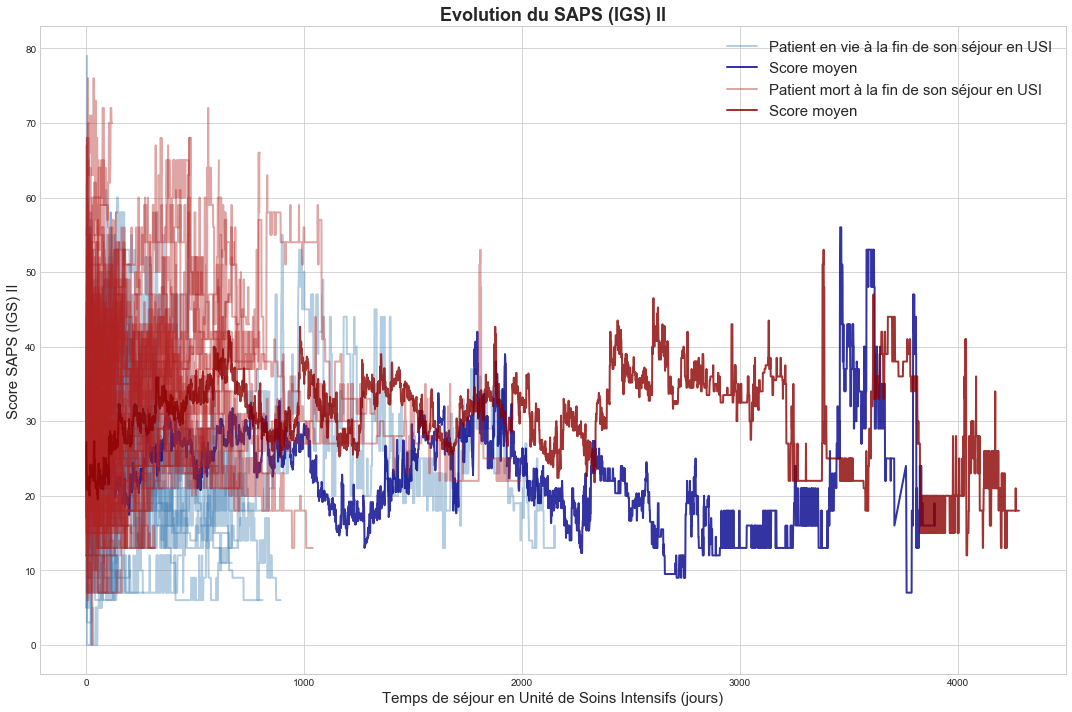

In [508]:
plt.figure(figsize=(15, 10))
x = [i for i in range(value_max + 1)]

for i, values in enumerate(sapsii_scores_alive):
    if i == 0:
        plt.plot(x[:values.size], values, linewidth=2, color="steelblue", linestyle="-", 
                 label="Patient en vie à la fin de son séjour en USI", alpha=0.4)
    else:
        plt.plot(x[:values.size], values, linewidth=2, color="steelblue", linestyle="-", alpha=0.4)

plt.plot(alive_mean_score, linewidth=2, color="darkblue", linestyle="-", 
         label="Score moyen", alpha=0.8)


for i, values in enumerate(sapsii_scores_dead):
    if i == 0:
        plt.plot(x[:values.size], values, linewidth=2, color="firebrick", linestyle="-", 
                 label="Patient mort à la fin de son séjour en USI", alpha=0.4)
    else:
        plt.plot(x[:values.size], values, linewidth=2, color="firebrick", linestyle="-", alpha=0.4)

plt.plot(dead_mean_score, linewidth=2, color="darkred", linestyle="-", 
         label="Score moyen", alpha=0.8)

plt.title("Evolution du SAPS (IGS) II", fontsize=18, fontweight="bold")
plt.ylabel("Score SAPS (IGS) II", fontsize=15)
plt.xlabel("Temps de séjour en Unité de Soins Intensifs", fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


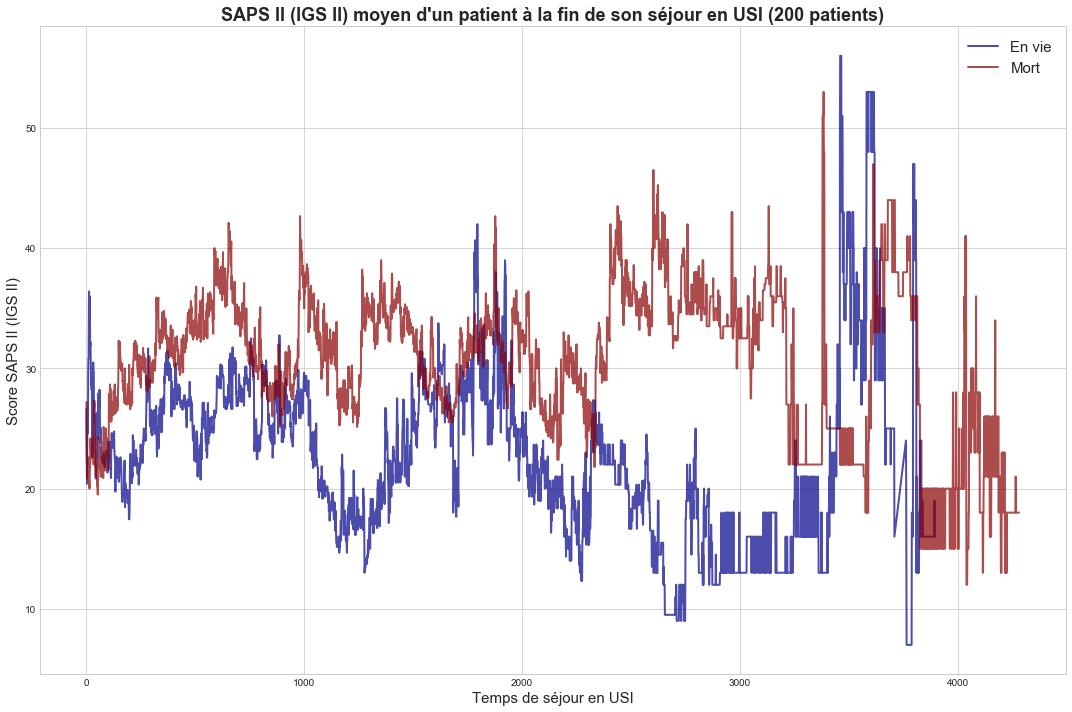

In [520]:
plt.figure(figsize=(15, 10))
x = [i for i in range(value_max + 1)]

plt.plot(alive_mean_score, linewidth=2, color="darkblue", linestyle="-", 
         label="En vie", alpha=0.7)


plt.plot(dead_mean_score, linewidth=2, color="darkred", linestyle="-", 
         label="Mort", alpha=0.7)

plt.title("SAPS II (IGS II) moyen d'un patient à la fin de son séjour en USI (200 patients)", fontsize=18, fontweight="bold")
plt.ylabel("Score SAPS II (IGS II)", fontsize=15)
plt.xlabel("Temps de séjour en USI", fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()

plt.show()

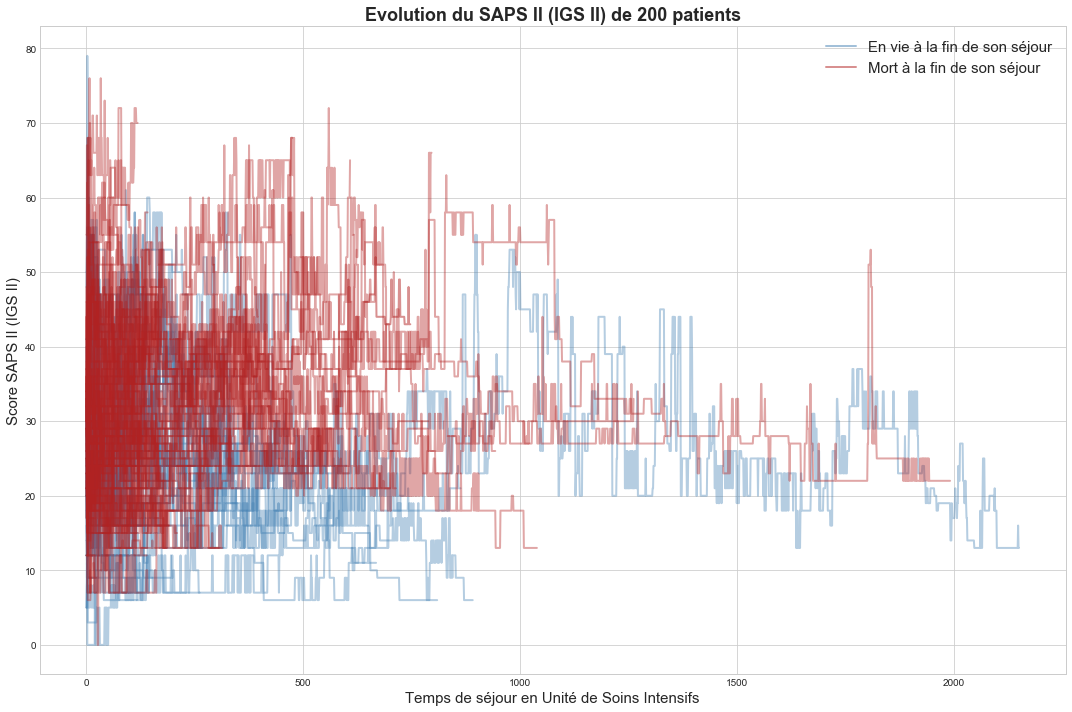

In [521]:
plt.figure(figsize=(15, 10))
x = [i for i in range(value_max + 1)]

for i, values in enumerate(sapsii_scores_alive):
    if i == 0:
        plt.plot(x[:values.size], values, linewidth=2, color="steelblue", linestyle="-", 
                 label="En vie à la fin de son séjour", alpha=0.5)
    else:
        plt.plot(x[:values.size], values, linewidth=2, color="steelblue", linestyle="-", alpha=0.4)

for i, values in enumerate(sapsii_scores_dead):
    if i == 0:
        plt.plot(x[:values.size], values, linewidth=2, color="firebrick", linestyle="-", 
                 label="Mort à la fin de son séjour", alpha=0.5)
    else:
        plt.plot(x[:values.size], values, linewidth=2, color="firebrick", linestyle="-", alpha=0.4)

plt.title("Evolution du SAPS II (IGS II) de 200 patients", fontsize=18, fontweight="bold")
plt.ylabel("Score SAPS II (IGS II)", fontsize=15)
plt.xlabel("Temps de séjour en Unité de Soins Intensifs", fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()